# Hotel Data Exploration

We chose the following cities for an analysis of hotel listing factors, and used information  for each city scraped from TripAdvisor (https://www.tripadvisor.com) on March 28, 2019:
* Amsterdam 
* Beijing
* Las Vegas
* Los Angeles
* Madrid
* New York
* Paris
* Sydney

We had trouble locating current, sufficiently large and detailed data files for hotels for use in comparison to Airbnb data. Many APIs we found seemed geared toward travel partner accounts, or returned range data instead of specific prices and/or ratings. We found a world hotel dataset here https://github.com/lucasmonteiro001/free-world-hotel-database/blob/master/hotels.csv.zip, and used this for initial analysis (see Hotel_Analysis directory) and geographical data. Since this file was dated 2016 and we were unsure of the original source and price units, we looked for additional data. This notebook uses data scraped from the TripAdvisor website.

The scraper script was obtained a from Scrapehero tutorial at https://www.scrapehero.com/how-to-scrape-tripadvisor/. The code was modified for Python 3 syntax, pandas inclusion, changes in the TripAdvisor page markup, and to loop through multiple pages. The script we used is "tripadvisor_scraper3.py" located in the scraper directory. The script takes parameters to run, and for these we chose "2019/03/29" for checkin, "2019/03/30" for checkout, and sort by "popularity". (These are Friday night hotel prices.) The code attempts to scrape the first 1,000 listings per locality, but there were less available for most of our cities.

This hotel dataset does not include geographical coordinates, as TripAdvisor uses their own geographical coding system. (Hotel locations were considered in the Hotel_Analysis notebook.)

Plots were used intermittently to help direct data exploration and data cleaning. For discussion of conclusions, see Airbnb_vs_Hotel.ipynb in main directory.

---

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
import math
import json
import scipy.stats as stats

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# gmaps and geojson
import geopy.distance
import gmaps
import gmaps.geojson_geometries

# Google developer API key
from config import gkey
gmaps.configure(api_key=gkey)

# List of Eight World Cities Chosen
cityL=["Amsterdam","Beijing","Las Vegas","Los Angeles","Madrid","New York","Paris","Sydney"]

# file to save geocodes for each city
geo_data_file = os.path.join("..","Resources","geocodes.csv")
# retrieve geography coords without re-running cell above
geodf = pd.read_csv(geo_data_file, index_col = "city")

In [2]:
# retrieve hotel info scraped from Tripadvisor

dfexists = False

for city in cityL:
    filename = city.lower()+"_data.csv"
    path = os.path.join("scraper",filename)
    #print(path)
    citydf = pd.read_csv(path)
    citydf["key"]=city
    if dfexists:
        hallcitydf = pd.concat([hallcitydf, citydf], ignore_index=True)
    else:
        hallcitydf = citydf
        dfexists = True


hallcitydf.head()

,booking_provider,checkIn,checkOut,hotel_features,hotel_name,locality,no_of_deals,price_per_night,reviews,tripadvisor_rating,url,key
0,Expedia.com,2019/03/29,2019/03/30,"Free Wifi,Room service",Hotel Estherea,amsterdam,14,$268,4457,4.5,http://www.tripadvisor.com/Hotel_Review-g18859...,Amsterdam
1,Booking.com,2019/03/29,2019/03/30,"Free Wifi,Restaurant,Visit hotel website",Ambassade Hotel,amsterdam,10,$260,1722,5.0,http://www.tripadvisor.com/Hotel_Review-g18859...,Amsterdam
2,Booking.com,2019/03/29,2019/03/30,"Free Wifi,Restaurant,Visit hotel website",Lloyd Hotel,amsterdam,12,$102,1975,4.0,http://www.tripadvisor.com/Hotel_Review-g18859...,Amsterdam
3,Booking.com,2019/03/29,2019/03/30,"Free Wifi,Fitness center",HOTEL2STAY,amsterdam,13,$138,1625,4.5,http://www.tripadvisor.com/Hotel_Review-g18859...,Amsterdam
4,Booking.com,2019/03/29,2019/03/30,"Free Wifi,Restaurant,Visit hotel website","Radisson Blu Hotel, Amsterdam",amsterdam,16,$278,3907,4.5,http://www.tripadvisor.com/Hotel_Review-g18859...,Amsterdam


In [3]:
# list cols in db
list(hallcitydf)

['booking_provider',
 'checkIn',
 'checkOut',
 'hotel_features',
 'hotel_name',
 'locality',
 'no_of_deals',
 'price_per_night',
 'reviews',
 'tripadvisor_rating',
 'url',
 'key']

In [4]:
hallcitydf.dtypes

booking_provider       object
checkIn                object
checkOut               object
hotel_features         object
hotel_name             object
locality               object
no_of_deals             int64
price_per_night        object
reviews                object
tripadvisor_rating    float64
url                    object
key                    object
dtype: object

In [5]:
hotcitydf=hallcitydf[['hotel_name', 'price_per_night','reviews','tripadvisor_rating','url','key']]
hotcitydf = hotcitydf.rename(columns={'price_per_night':'price','tripadvisor_rating':'rating'})
hotcitydf.head()

# convert price to float
if hotcitydf["price"].dtype == 'object':
    hotcitydf["price"] = hotcitydf["price"].str.replace('$', '')
    hotcitydf["price"] = hotcitydf["price"].str.replace(',', '')
    hotcitydf["price"] = hotcitydf["price"].astype(float)
    
# convert reviews to float
if hotcitydf["reviews"].dtype == 'object':
    hotcitydf["reviews"] = hotcitydf["reviews"].str.replace('reviews', '')
    hotcitydf["reviews"] = hotcitydf["reviews"].str.replace('review', '')
    hotcitydf["reviews"] = hotcitydf["reviews"].str.replace(' ', '')
    hotcitydf["reviews"] = hotcitydf["reviews"].str.replace(',', '')
    hotcitydf["reviews"] = hotcitydf["reviews"].astype(float)
    
# drop listings with price = 0
hotcitydf = hotcitydf.loc[hotcitydf['price']!=0]
hotcitydf["price"].describe()

# drop rows without a 'price'
hotcitydf = hotcitydf.dropna(subset=['price']) 

# save to .csv 
hotelCity_file = os.path.join("saveData","hotelCity.csv")
hotcitydf.to_csv(hotelCity_file)

# convert rating to scale of 100
hotcitydf["rating"]=20 * hotcitydf["rating"]
hotcitydf.describe()

,price,reviews,rating
count,3954.000000,2910.000000,3697.000000
mean,157.622408,1047.556357,78.988369
std,143.292802,2534.415847,12.544472
min,15.000000,0.000000,20.000000
25%,83.000000,41.000000,70.000000
50%,129.000000,243.500000,80.000000
75%,188.000000,1099.000000,90.000000
max,3463.000000,38758.000000,100.000000


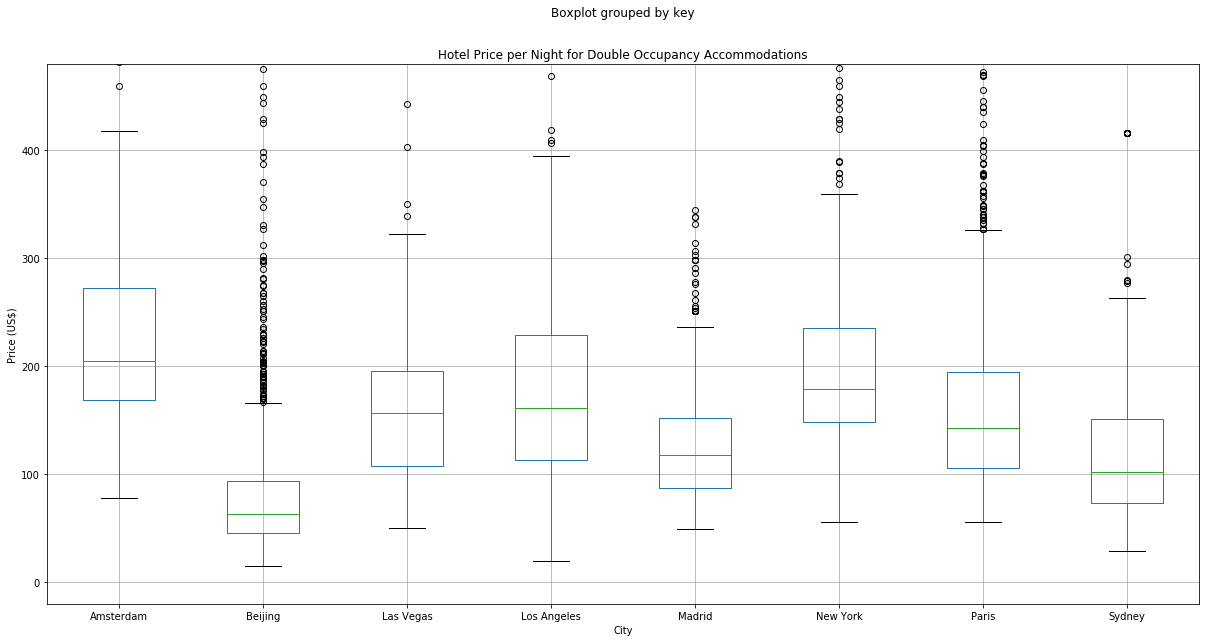

In [6]:
# Show box plot with price ranges per night in each city
hotcitydf.boxplot("price", by="key", figsize=(20, 10))
# adjust ylim because of hugely, expensive outliers
plt.ylim(-20,480)
plt.xlabel("City")
plt.ylabel("Price (US$)")
plt.title("Hotel Price per Night for Double Occupancy Accommodations")

# Save the Figure
imagepath = os.path.join("saveImages","HotelPriceBoxplot.png")
plt.savefig(imagepath)

plt.show()



In [7]:
# Null hypothesis: Hotel prices are about the same in each city, run ANOVA
# Extract individual groups
g1 = hotcitydf[hotcitydf["key"] == "Amsterdam"]["price"]
g2 = hotcitydf[hotcitydf["key"] == "Beijing"]["price"]
g3 = hotcitydf[hotcitydf["key"] == "Las Vegas"]["price"]
g4 = hotcitydf[hotcitydf["key"] == "Los Angeles"]["price"]
g5 = hotcitydf[hotcitydf["key"] == "Madrid"]["price"]
g6 = hotcitydf[hotcitydf["key"] == "New York"]["price"]
g7 = hotcitydf[hotcitydf["key"] == "Paris"]["price"]
g8 = hotcitydf[hotcitydf["key"] == "Sydney"]["price"]

# Perform the ANOVA
stats.f_oneway(g1, g2, g3, g4, g5, g6, g7, g8)

F_onewayResult(statistic=68.52842096834225, pvalue=1.0113350127400278e-93)

In [8]:
# Based on pvalue = 1.011334e-93, there is a statistically significant difference in hotel prices among the 8 cities

meandf = hotcitydf.groupby(["key"])[['price','rating']].mean()
meandf

,price,rating
key,,
Amsterdam,243.514793,83.491124
Beijing,89.730417,76.429298
Las Vegas,173.022346,73.851351
Los Angeles,187.151442,70.212202
Madrid,135.358369,80.988506
New York,219.503417,82.041284
Paris,181.812261,84.378378
Sydney,138.771318,72.901786


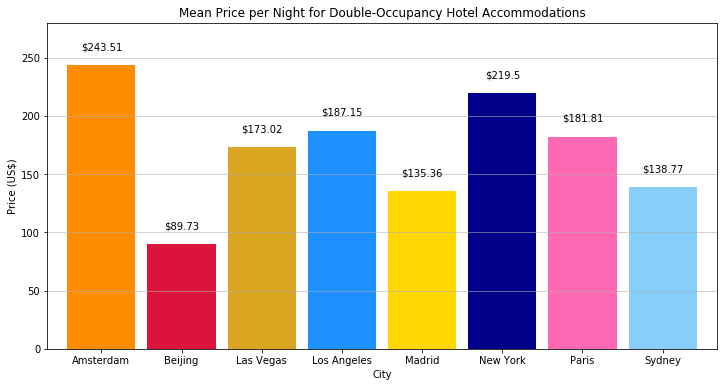

In [9]:
# plot the city mean hotel prices
colors = ["darkorange", "crimson", "goldenrod", "dodgerblue", "gold", "darkblue", "hotpink","lightskyblue"]

plt.figure( figsize=(12,6))
myplot = meandf['price'].plot(kind='bar', width=.85, color = colors)
plt.xticks(rotation=0)
plt.xlabel("City")
plt.grid(axis='y', alpha=.7)
plt.ylabel("Price (US$)")
plt.ylim(0,280)
plt.title ("Mean Price per Night for Double-Occupancy Hotel Accommodations")
# Make some labels.
labels = ['$'+str(round(s,2)) for s in  meandf['price']]


# Use functions to label the percentages of changes
def labelbar(bar, label, **kwargs):
    height = bar.get_height()
    if not 'pos' in kwargs:
        pos = "top"
    else:
        pos = kwargs["pos"]
    if not 'ybot' in kwargs:
        ybot = 0
    else:
        ybot = kwargs["ybot"]
    offset = 16*abs(height)/height
    if (pos == "top"):
        placement = height+offset -ybot
    else:
        placement = offset
    plt.text(bar.get_x() + bar.get_width() / 2, placement, label,
            ha='center', va='center', color="black")


# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# Save the Figure
imagepath = os.path.join("saveImages","HotelMeanPrices.png")
plt.savefig(imagepath)

plt.show()

In [10]:
meanAirbnb_file = os.path.join("..","airbnb","saveData","meanAirbnb.csv")
airbnbdf = pd.read_csv(meanAirbnb_file, index_col = "key")
airbnbdf

,price,review_scores_rating
key,,
Amsterdam,118.276573,95.157141
Beijing,343.631634,94.917943
Las Vegas,72.100719,95.489209
Los Angeles,96.618328,95.039733
Madrid,55.246704,92.673296
New York,109.047070,94.055740
Paris,77.281388,92.974650
Sydney,112.729176,93.509404


In [11]:
bothmeandf = meandf.rename(columns = {"price":"hotel_price", "rating":"hotel_rating"})
bothmeandf["airbnb price"]=airbnbdf["price"]
bothmeandf["airbnb rating"]=airbnbdf["review_scores_rating"]
# save to .csv 
bothmean_file = os.path.join("saveData","bothmean.csv")
bothmeandf.to_csv(bothmean_file)

bothmeandf

,hotel_price,hotel_rating,airbnb price,airbnb rating
key,,,,
Amsterdam,243.514793,83.491124,118.276573,95.157141
Beijing,89.730417,76.429298,343.631634,94.917943
Las Vegas,173.022346,73.851351,72.100719,95.489209
Los Angeles,187.151442,70.212202,96.618328,95.039733
Madrid,135.358369,80.988506,55.246704,92.673296
New York,219.503417,82.041284,109.047070,94.055740
Paris,181.812261,84.378378,77.281388,92.974650
Sydney,138.771318,72.901786,112.729176,93.509404


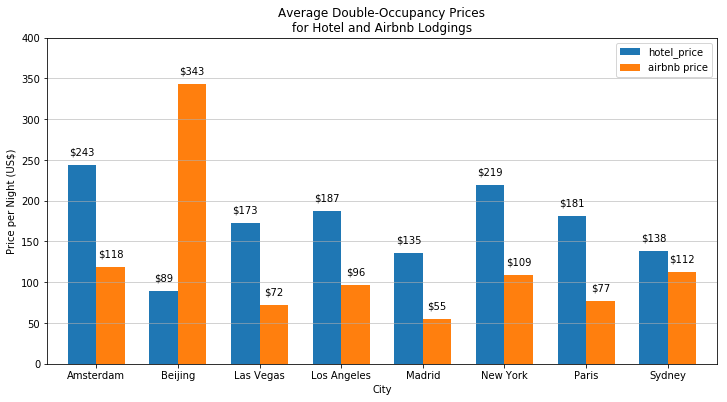

In [67]:
# plot Airbnb vs Hotel

myplot = bothmeandf[["hotel_price","airbnb price"]].plot(kind='bar', figsize = (12,6), width=.7)
plt.xlabel("City")
plt.ylabel("Price per Night (US$)")
plt.xticks(rotation=0)
plt.title (f"Average Double-Occupancy Prices{os.linesep}for Hotel and Airbnb Lodgings")
plt.grid(axis='y', alpha=.7)
plt.ylim(0,400)


# Make some labels
vals = [*bothmeandf['hotel_price'], *bothmeandf['airbnb price']]
labels = ["$"+str(int(val))  for val in vals]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label)

# Save the Figure
imagepath = os.path.join("saveImages","AverageHotelandAirbnb.png")
plt.savefig(imagepath)

plt.show()

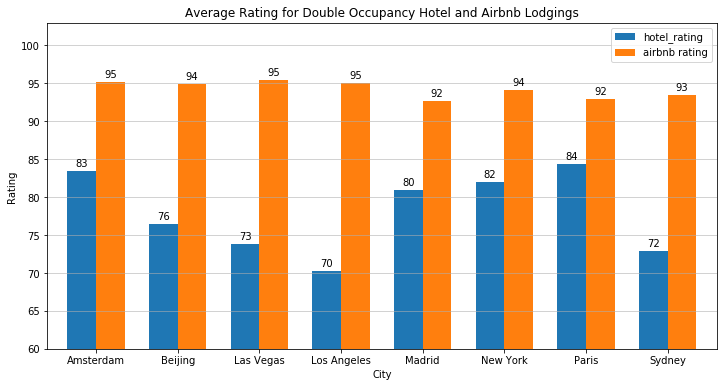

In [68]:
# plot Airbnb vs Hotel Rating

myplot = bothmeandf[["hotel_rating","airbnb rating"]].plot(kind='bar', figsize = (12,6), width=.7)
plt.xlabel("City")
plt.ylabel("Rating")
plt.xticks(rotation=0)
plt.title (f"Average Rating for Double Occupancy Hotel and Airbnb Lodgings")
plt.grid(axis='y', alpha=.7)
plt.ylim(60,103)

# Make some labels
vals = [*bothmeandf['hotel_rating'], *bothmeandf['airbnb rating']]
labels = [str(int(val)) for val in vals]

# Call functions to implement the function calls
for bar, label in zip(myplot.patches, labels):
    labelbar(bar, label, ybot=15)

# Save the Figure
imagepath = os.path.join("saveImages","HotelAirbnbRating.png")
plt.savefig(imagepath)

plt.show()


In [46]:
city = "New York"
mcitydf = hotcitydf.loc[hotcitydf["key"]==city]
mcitydf.head()

,hotel_name,price,reviews,rating,url,key
4162,Roger Smith Hotel,199.0,2558,4.0,http://www.tripadvisor.com/Hotel_Review-g60763...,New York
4163,YOTEL New York,141.0,12365,4.5,http://www.tripadvisor.com/Hotel_Review-g60763...,New York
4164,The Bentley Hotel,142.0,4798,4.0,http://www.tripadvisor.com/Hotel_Review-g60763...,New York
4165,Crowne Plaza Times Square Manhattan,149.0,11204,4.0,http://www.tripadvisor.com/Hotel_Review-g60763...,New York
4166,Arthouse Hotel New York City,207.0,6691,4.0,http://www.tripadvisor.com/Hotel_Review-g60763...,New York


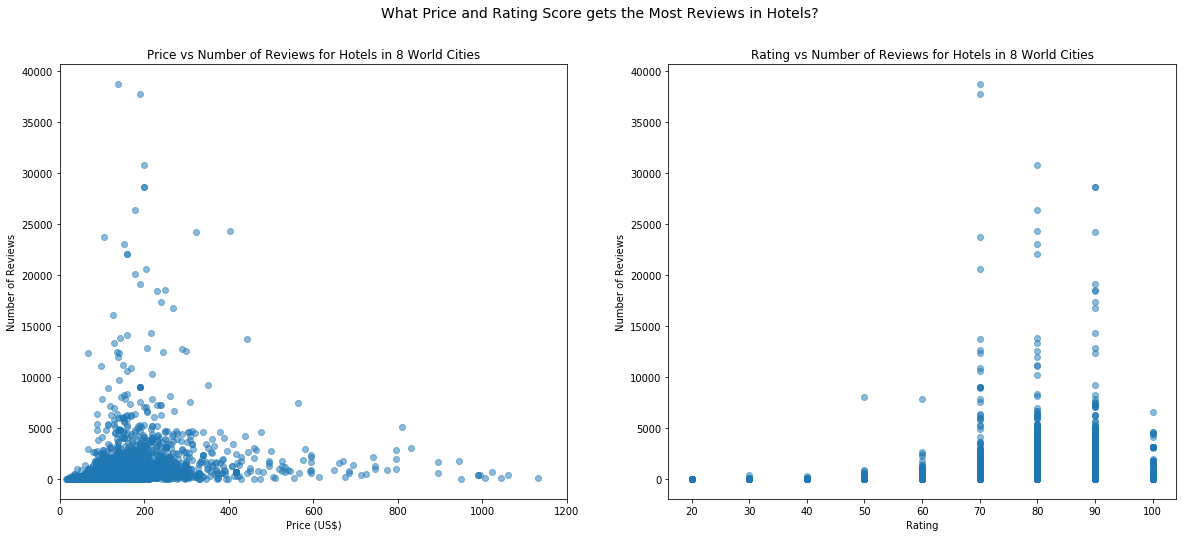

In [73]:
# Plot price vs number of reviews and rating vs number of reviews for all cities in hotel data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
ax1.scatter(hotcitydf["price"],hotcitydf["reviews"], alpha=.5)
ax1.set_title("Price vs Number of Reviews for Hotels in 8 World Cities")
ax1.xaxis.set_label_text('Price (US$)')
ax1.yaxis.set_label_text("Number of Reviews")
ax1.set_xlim(0,1200)

ax2.scatter(hotcitydf["rating"],hotcitydf["reviews"], alpha=.5)
ax2.set_title("Rating vs Number of Reviews for Hotels in 8 World Cities")
ax2.xaxis.set_label_text('Rating')
ax2.yaxis.set_label_text("Number of Reviews")

fig.suptitle(f"What Price and Rating Score gets the Most Reviews in Hotels?", fontsize=14)

# Save the Figure
imagepath = os.path.join("saveImages","HotelRatingsScatter.png")
plt.savefig(imagepath)

fig.show()

In [84]:
# import the double-occupancy airbnb data for comparison

airbnb_file = os.path.join("..","airbnb","saveData","airbnb_double.csv")
airalldf = pd.read_csv(airbnb_file, index_col=False)
airalldf = airalldf.drop(columns=['Unnamed: 0'])
airalldf.head()

,id,latitude,longitude,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,price,number_of_reviews,review_scores_rating,key,center_distance
0,2818,52.36575,4.94142,Oostelijk Havengebied - Indische Buurt,NaN,Private room,2,59.0,250,97.0,Amsterdam,2.590703
1,20168,52.36509,4.89354,Centrum-Oost,NaN,Entire home/apt,2,80.0,251,87.0,Amsterdam,0.754776
2,27886,52.38673,4.89208,Centrum-West,NaN,Private room,2,150.0,180,99.0,Amsterdam,2.227640
3,28658,52.37534,4.85729,Bos en Lommer,NaN,Private room,2,65.0,444,93.0,Amsterdam,3.256001
4,28871,52.36719,4.89092,Centrum-West,NaN,Private room,2,75.0,240,97.0,Amsterdam,0.865582


Amsterdam:
t-test pvalue = 2.894293204366432e-24
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Beijing:
t-test pvalue = 0.0
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Las Vegas:
t-test pvalue = 7.266712284889231e-19
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Los Angeles:
t-test pvalue = 2.2025875099157772e-48
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Madrid:
t-test pvalue = 1.4296739113739913e-53
Hotel and Airbnb price differences vary significantly - they are not the same.
---
New York:
t-test pvalue = 1.1742594809778246e-46
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Paris:
t-test pvalue = 7.175641749837913e-88
Hotel and Airbnb price differences vary significantly - they are not the same.
---
Sydney:
t-test pvalue = 0.068381427754927
Hotel and Airbnb price differences are NOT statistically 

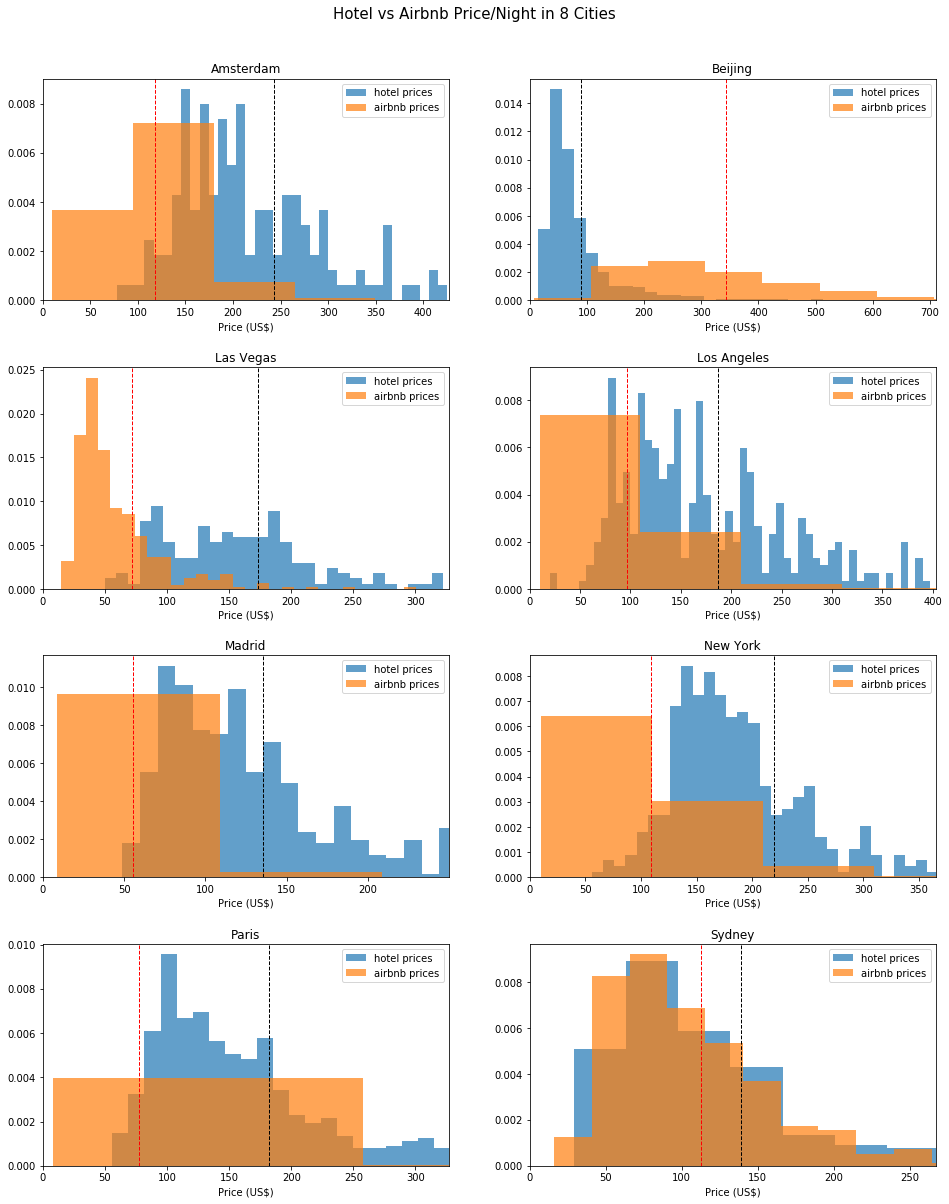

In [129]:
# Test city sample prices between airbnb and hotels - are they statistically the same?

# function to plot by city, cin is subplot index
def plotdata(city, cin):
    # Histogram Plot of Data
    hotdf = hotcitydf.loc[hotcitydf["key"]==city]
    airdf = airalldf.loc[airalldf["key"]==city]
    plt.subplot(4, 2, cin)
    plt.hist(hotdf['price'], 100, density=True, alpha=0.7, label="hotel prices")
    plt.hist(airdf['price'], 100, density=True, alpha=0.7, label="airbnb prices")
    plt.axvline(hotdf['price'].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(airdf['price'].mean(), color='red', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    h75 = np.percentile(hotdf['price'], 75)
    a75 = np.percentile(airdf['price'], 75)
    
    if h75>a75:
        x75 = h75
        x25 = np.percentile(hotdf['price'], 25)
    else:
        x75 = a75
        x25 = np.percentile(airdf['price'], 25)
    
    xmax = x75 + 1.5 * (x75 - x25)
    plt.xlim(0,xmax)
    plt.xlabel("Price (US$)")
    plt.title(f"{city}")
    
    # do independent t-test
    print(f"{city}:")
    tresults = stats.ttest_ind(hotdf['price'], airdf['price'], equal_var=False)
    print(f't-test pvalue = {tresults[1]}')
    if tresults[1] >.05:
        print('Hotel and Airbnb price differences are NOT statistically significant.')
    else:
        print('Hotel and Airbnb price differences vary significantly - they are not the same.')
    print("---")

plt.figure(figsize=(16,20))

cin= 1
for city in cityL:
    plotdata(city, cin)
    cin+= 1
    
plt.subplots_adjust(hspace=.3)
plt.suptitle("Hotel vs Airbnb Price/Night in 8 Cities",fontsize = 15, y=.93)

# Save the Figure
imagepath = os.path.join("saveImages","priceHistogramComparisons.png")
plt.savefig(imagepath)

plt.show()